# Loaders

## Libraries

- Import necessary Libraries

In [1]:
!pip install dash
!pip install xgboost
!pip install catboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [2]:
import time
# Computational Libs
import numpy as np
import pandas as pd
# Viz Libs
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
from holoviews import opts
# Helper and Utility Libs for Pre-processing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Model Libs
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Hyper-parameter Libs
import optuna
from sklearn.model_selection import cross_val_score

## Data loading

- Load the chocolate sales data from the provided CSV file into a pandas DataFrame.

In [3]:
try:
    df = pd.read_csv('/kaggle/input/chocolate-sales/2025-4-26-公众号python机器学习MLChocolate Sales.csv')
    display(df)
except:
    print('Error loading the data file')

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184
...,...,...,...,...,...,...
1089,Karlen McCaffrey,Australia,Spicy Special Slims,17-May-22,"$4,410",323
1090,Jehu Rudeforth,USA,White Choc,07-Jun-22,"$6,559",119
1091,Ches Bonnell,Canada,Organic Choco Syrup,26-Jul-22,$574,217
1092,Dotty Strutley,India,Eclairs,28-Jul-22,"$2,086",384


# Cleaners

## Data exploration

- Identify missing values, data types, and basic statistics.
- Determine the shape of the data, the distribution of key variables (Sales, Boxes Shipped, etc.), and the correlation between variables.


In [4]:
# Clean the 'Amount' column
df['Amount'] = df['Amount'].str.replace(r'[$,]', '', regex=True).astype(float)
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
# Create new features from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Display the shape
print("\nShape of the DataFrame:", df.shape)
# Display data type information
print("\nData types of each column:\n")
df.info()


Shape of the DataFrame: (1094, 8)

Data types of each column:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Sales Person   1094 non-null   object        
 1   Country        1094 non-null   object        
 2   Product        1094 non-null   object        
 3   Date           1094 non-null   datetime64[ns]
 4   Amount         1094 non-null   float64       
 5   Boxes Shipped  1094 non-null   int64         
 6   Month          1094 non-null   int32         
 7   Year           1094 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(3)
memory usage: 60.0+ KB


In [5]:
df

,Sales Person,Country,Product,Date,Amount,Boxes Shipped,Month,Year
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,1,2022
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,8,2022
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,7,2022
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,4,2022
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2,2022
...,...,...,...,...,...,...,...,...
1089,Karlen McCaffrey,Australia,Spicy Special Slims,2022-05-17,4410.0,323,5,2022
1090,Jehu Rudeforth,USA,White Choc,2022-06-07,6559.0,119,6,2022
1091,Ches Bonnell,Canada,Organic Choco Syrup,2022-07-26,574.0,217,7,2022
1092,Dotty Strutley,India,Eclairs,2022-07-28,2086.0,384,7,2022


In [6]:
# Generate descriptive statistics
print("\nDescriptive statistics:\n", df.describe(include='all'))


Descriptive statistics:
          Sales Person    Country  Product                           Date  \
count            1094       1094     1094                           1094   
unique             25          6       22                            NaN   
top     Kelci Walkden  Australia  Eclairs                            NaN   
freq               54        205       60                            NaN   
mean              NaN        NaN      NaN  2022-05-03 09:04:56.160877568   
min               NaN        NaN      NaN            2022-01-03 00:00:00   
25%               NaN        NaN      NaN            2022-03-02 00:00:00   
50%               NaN        NaN      NaN            2022-05-11 00:00:00   
75%               NaN        NaN      NaN            2022-07-04 00:00:00   
max               NaN        NaN      NaN            2022-08-31 00:00:00   
std               NaN        NaN      NaN                            NaN   

              Amount  Boxes Shipped        Month    Year  
co

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



Distribution of 'Amount' and 'Boxes Shipped':


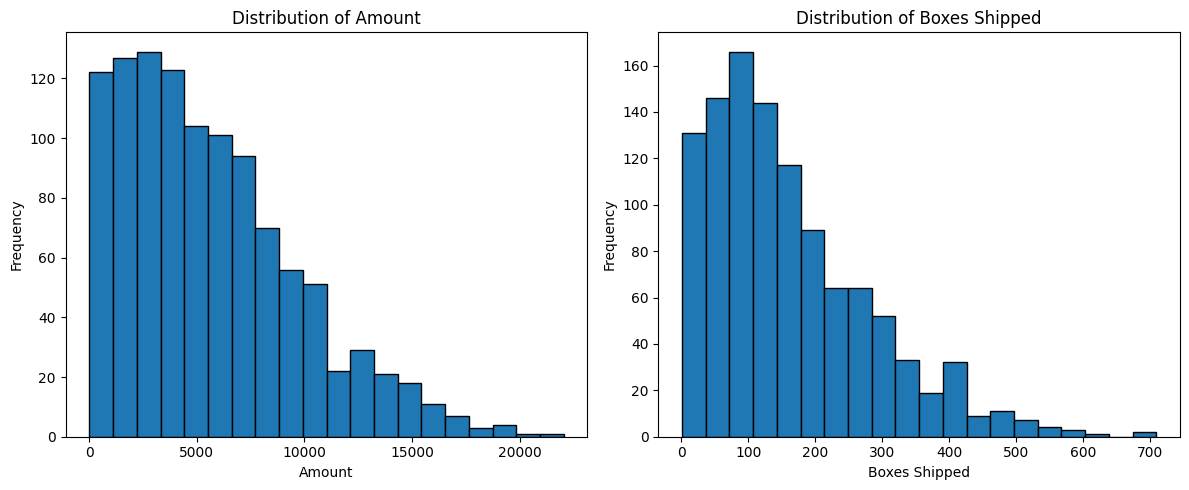

In [7]:
# Analyze the distribution of key variables
print("\nDistribution of 'Amount' and 'Boxes Shipped':")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Amount'], bins=20, edgecolor = "black")  # Adjust the number of bins as needed
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount')

plt.subplot(1, 2, 2)
plt.hist(df['Boxes Shipped'], bins=20, edgecolor = "black")  # Adjust the number of bins as needed
plt.xlabel('Boxes Shipped')
plt.ylabel('Frequency')
plt.title('Distribution of Boxes Shipped')
plt.tight_layout()
plt.show()


Correlation Matrix:
                  Amount  Boxes Shipped    Month  Year
Amount         1.000000      -0.018827 -0.05171   NaN
Boxes Shipped -0.018827       1.000000 -0.05746   NaN
Month         -0.051710      -0.057460  1.00000   NaN
Year                NaN            NaN      NaN   NaN


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


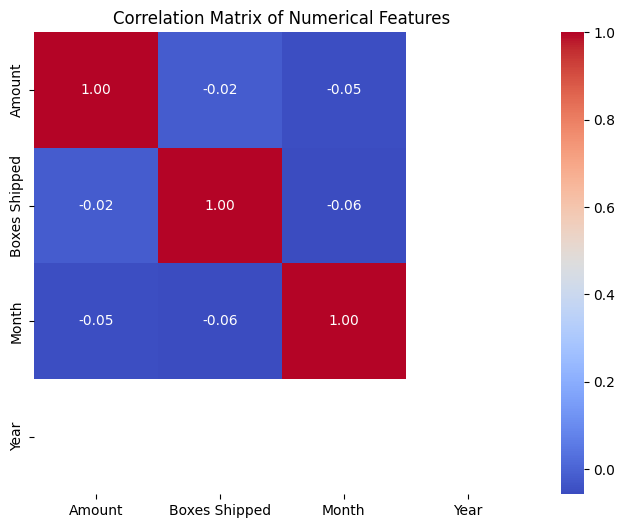

In [8]:
# Calculate and visualize the correlation matrix (with numeric_only=True)
correlation_matrix = df.corr(numeric_only=True)
print("\nCorrelation Matrix:\n", correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Data cleaning

- Clean the data by handling missing values and outliers in the 'Amount' and 'Boxes Shipped' columns.

In [9]:
# Check for missing values
print(df.isnull().sum())

# Handle outliers using winsorization
def winsorize_outliers(series, limits=(0.05, 0.95)):
    lower_limit = series.quantile(limits[0])
    upper_limit = series.quantile(limits[1])
    winsorized_series = series.clip(lower_limit, upper_limit)
    return winsorized_series

for col in ['Amount', 'Boxes Shipped']:
    df[col] = winsorize_outliers(df[col])
    print(f"Winsorized outliers in '{col}'.")

print(df.describe())

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
Month            0
Year             0
dtype: int64
Winsorized outliers in 'Amount'.
Winsorized outliers in 'Boxes Shipped'.
                                Date        Amount  Boxes Shipped  \
count                           1094   1094.000000    1094.000000   
mean   2022-05-03 09:04:56.160877568   5551.894196     158.680759   
min              2022-01-03 00:00:00    487.550000      15.650000   
25%              2022-03-02 00:00:00   2390.500000      70.000000   
50%              2022-05-11 00:00:00   4868.500000     135.000000   
75%              2022-07-04 00:00:00   8027.250000     228.750000   
max              2022-08-31 00:00:00  13706.000000     409.000000   
std                              NaN   3802.914763     111.566361   

             Month    Year  
count  1094.000000  1094.0  
mean      4.576782  2022.0  
min       1.000000  2022.0  
25%       3.000000  2022

## Data wrangling

- Prepare the data for analysis and modeling.  This includes creating new features, converting data types, and handling categorical variables.


In [10]:
# Calculate the 'Profit' column (assuming a 20% profit margin)
df['Profit'] = df['Amount'] * 0.20

# Display the updated DataFrame
print(df.head())

     Sales Person    Country              Product       Date   Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco 2022-01-04   5320.0   
1     Van Tuxwell      India        85% Dark Bars 2022-08-01   7896.0   
2    Gigi Bohling      India  Peanut Butter Cubes 2022-07-07   4501.0   
3    Jan Morforth  Australia  Peanut Butter Cubes 2022-04-27  12726.0   
4  Jehu Rudeforth         UK  Peanut Butter Cubes 2022-02-24  13685.0   

   Boxes Shipped  Month  Year  Profit  
0          180.0      1  2022  1064.0  
1           94.0      8  2022  1579.2  
2           91.0      7  2022   900.2  
3          342.0      4  2022  2545.2  
4          184.0      2  2022  2737.0  


# Viewers

## Data analysis

- Perform a comprehensive analysis of the chocolate sales data to answer specific business questions.


In [11]:
# Sales Distribution
sales_stats = df['Amount'].describe()
print(sales_stats)

# Identify best and worst-selling products
product_sales = df.groupby('Product')['Amount'].sum()
print("\nProduct Sales:\n", product_sales)
best_selling_product = product_sales.idxmax()
worst_selling_product = product_sales.idxmin()
print(f"\nBest Selling Product: {best_selling_product}")
print(f"Worst Selling Product: {worst_selling_product}")

# Analyze sales trends over time
yearly_sales = df.groupby('Year')['Amount'].sum()
print("\nYearly Sales:\n", yearly_sales)
monthly_sales = df.groupby('Month')['Amount'].sum()
print("\nMonthly Sales:\n", monthly_sales)

# Relationship between sales amount and boxes shipped
correlation = df['Amount'].corr(df['Boxes Shipped'])
print(f"\nCorrelation between Sales Amount and Boxes Shipped: {correlation}")

# Sales contribution of each country
country_sales = df.groupby('Country')['Amount'].sum()
print("\nCountry Sales:\n", country_sales)

# Salesperson performance
salesperson_sales = df.groupby('Sales Person')['Amount'].sum()
print("\nSalesperson Performance:\n", salesperson_sales)

# Combined category analysis - Example: Product performance in each country
product_country_sales = df.groupby(['Product', 'Country'])['Amount'].sum().unstack()
print("\nProduct Performance by Country:\n", product_country_sales)

count     1094.000000
mean      5551.894196
std       3802.914763
min        487.550000
25%       2390.500000
50%       4868.500000
75%       8027.250000
max      13706.000000
Name: Amount, dtype: float64

Product Sales:
 Product
50% Dark Bites          340946.55
70% Dark Bites          212260.65
85% Dark Bars           292620.65
99% Dark & Pure         297882.20
After Nines             254003.75
Almond Choco            275613.10
Baker's Choco Chips     245765.10
Caramel Stuffed Bars    227821.65
Choco Coated Almonds    237220.55
Drinking Coco           253021.30
Eclairs                 306882.10
Fruit & Nut Bars        258154.75
Manuka Honey Choco      268592.10
Milk Bars               264126.10
Mint Chip Choco         272108.55
Orange Choco            255408.65
Organic Choco Syrup     276061.10
Peanut Butter Cubes     313144.65
Raspberry Choco         261807.00
Smooth Sliky Salty      336501.55
Spicy Special Slims     294615.65
White Choc              329214.55
Name: Amount, dtype: f

## Data visualization

- Create a variety of visualizations to represent the findings from the data analysis.

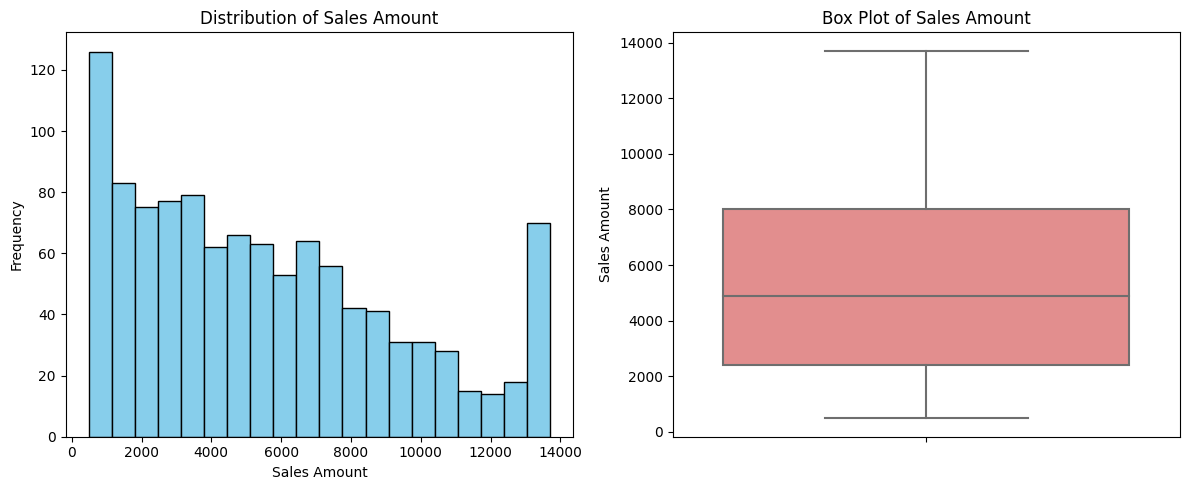

In [12]:
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df['Amount'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Sales Amount')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Amount'], color='lightcoral')
plt.ylabel('Sales Amount')
plt.title('Box Plot of Sales Amount')

plt.tight_layout()
plt.show()

In [13]:
# Identify categorical columns
categorical_cols = ['Sales Person', 'Country', 'Product']

# Apply one-hot encoding to categorical features
df_copy = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Display the updated DataFrame
print(df.head())

     Sales Person    Country              Product       Date   Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco 2022-01-04   5320.0   
1     Van Tuxwell      India        85% Dark Bars 2022-08-01   7896.0   
2    Gigi Bohling      India  Peanut Butter Cubes 2022-07-07   4501.0   
3    Jan Morforth  Australia  Peanut Butter Cubes 2022-04-27  12726.0   
4  Jehu Rudeforth         UK  Peanut Butter Cubes 2022-02-24  13685.0   

   Boxes Shipped  Month  Year  Profit  
0          180.0      1  2022  1064.0  
1           94.0      8  2022  1579.2  
2           91.0      7  2022   900.2  
3          342.0      4  2022  2545.2  
4          184.0      2  2022  2737.0  


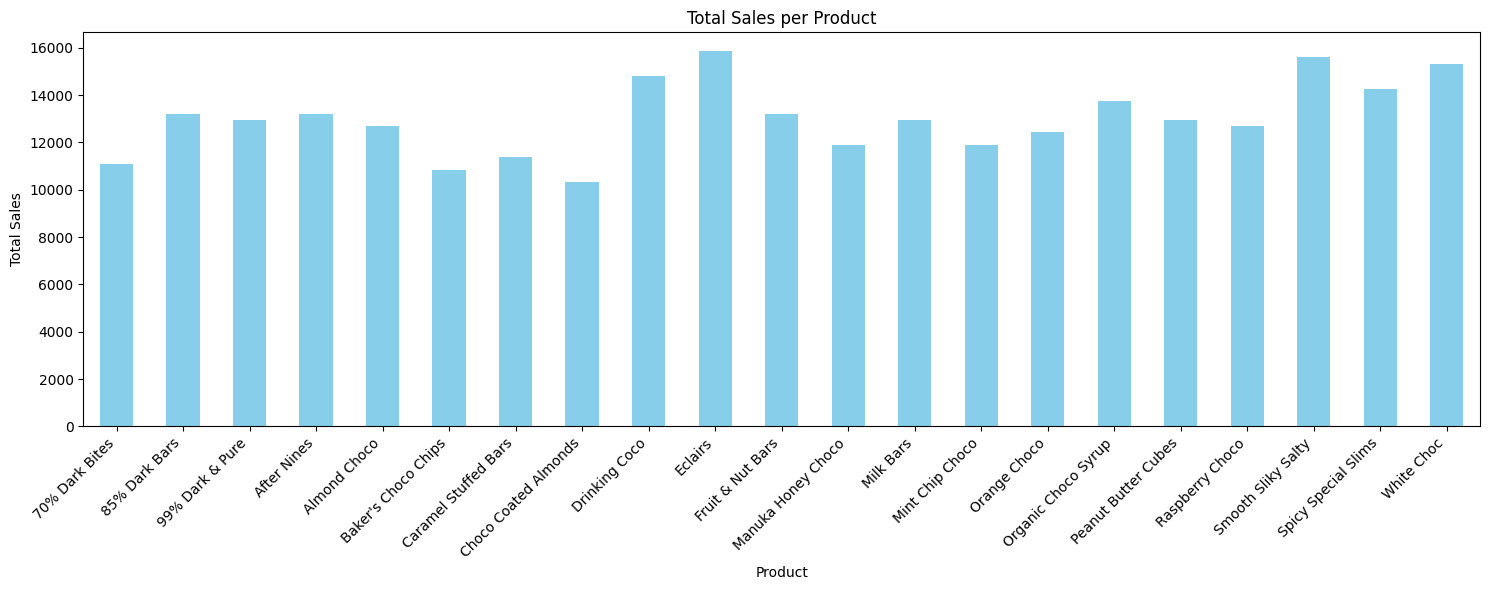

In [14]:
product_columns = [col for col in df_copy.columns if 'Product_' in col]
product_sales = df_copy[product_columns].sum() * df_copy['Amount'].mean() / len(product_columns)

plt.figure(figsize=(15, 6))
ax = product_sales.plot(kind='bar', color='skyblue')
ax.set_xticklabels([col_name.split('_')[1] for col_name in product_columns], rotation=45)
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.title('Total Sales per Product')
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

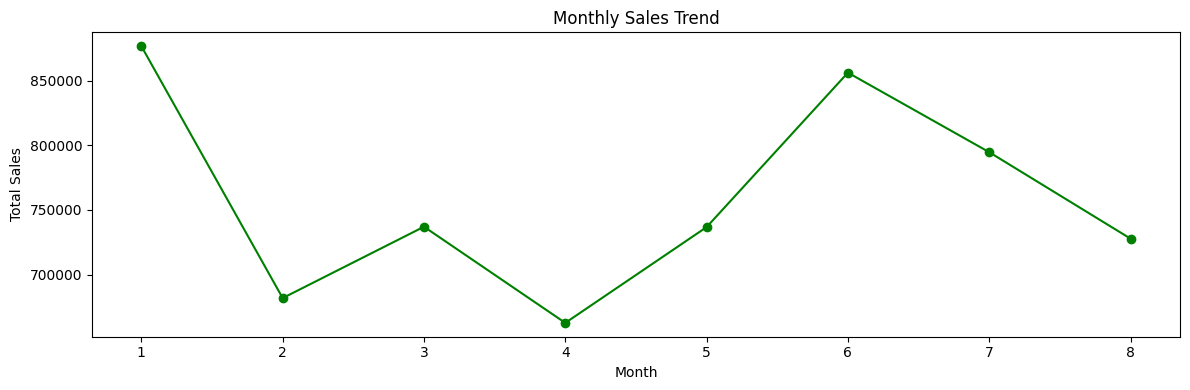

In [15]:
plt.figure(figsize=(12, 4))

# Monthly Sales Trend
plt.subplot(1, 1, 1)
plt.plot(df.groupby('Month')['Amount'].sum(), marker='o', linestyle='-', color='green')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend')

plt.tight_layout()
plt.show()

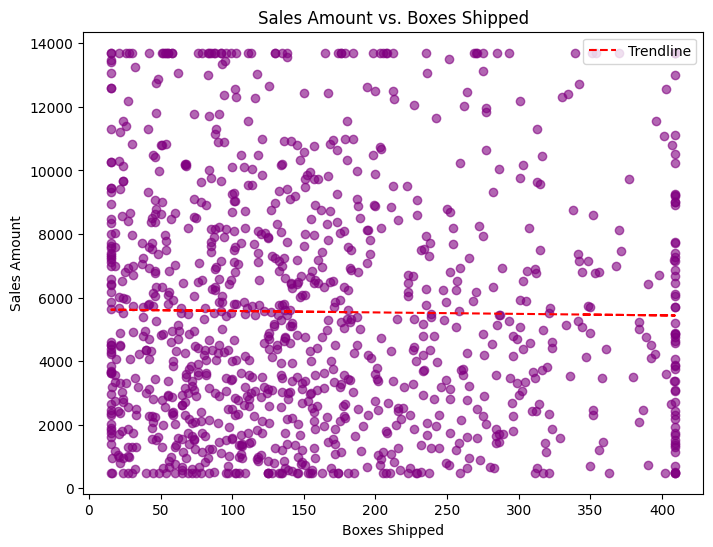

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Boxes Shipped'], df['Amount'], color='purple', alpha=0.6)
plt.xlabel('Boxes Shipped')
plt.ylabel('Sales Amount')
plt.title('Sales Amount vs. Boxes Shipped')

# Calculate and plot the trendline
z = np.polyfit(df['Boxes Shipped'], df['Amount'], 1)
p = np.poly1d(z)
plt.plot(df['Boxes Shipped'], p(df['Boxes Shipped']), color='red', linestyle='--', label='Trendline')
plt.legend()

plt.show()

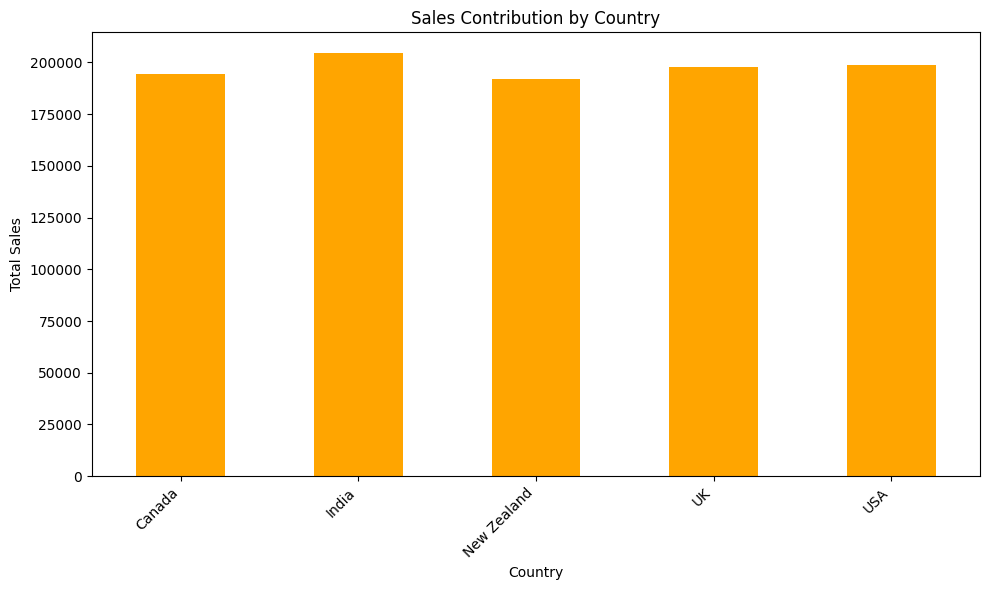

In [17]:
country_columns = [col for col in df_copy.columns if 'Country_' in col]
country_sales = df_copy[country_columns].sum() * df_copy['Amount'].mean() / len(country_columns)

plt.figure(figsize=(10, 6))
ax = country_sales.plot(kind='bar', color='orange')
ax.set_xticklabels([col_name.split('_')[1] for col_name in country_columns], rotation=45)
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Sales Contribution by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

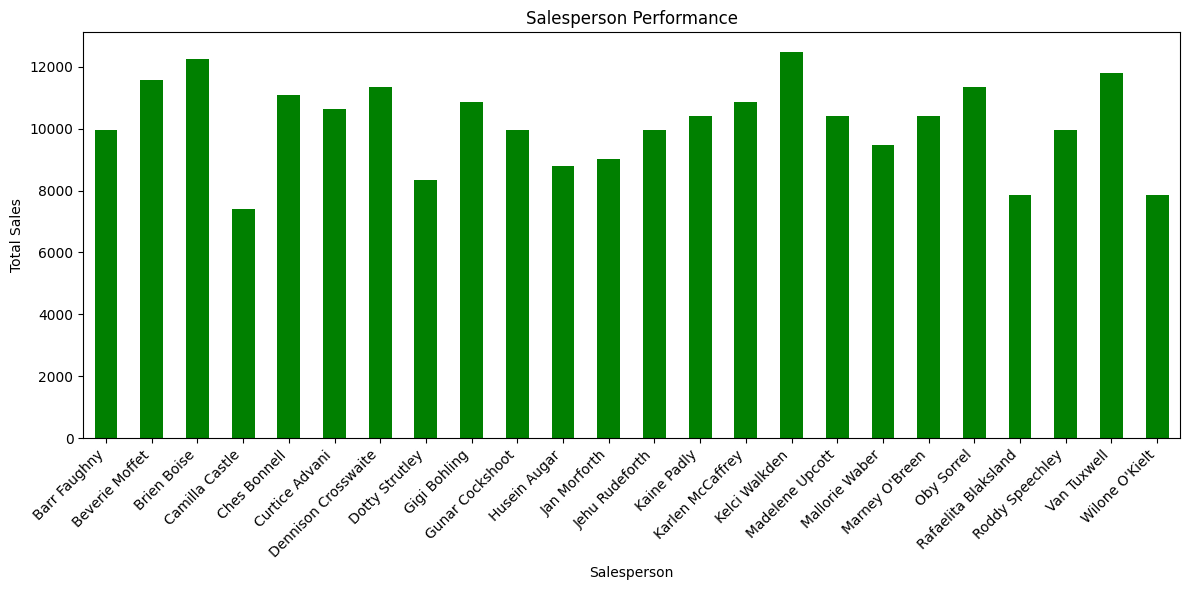

In [18]:
salesperson_columns = [col for col in df_copy.columns if 'Sales Person_' in col]
salesperson_performance = df_copy[salesperson_columns].sum() * df_copy['Amount'].mean() / len(salesperson_columns)

plt.figure(figsize=(12, 6))
ax = salesperson_performance.plot(kind='bar', color='green')
ax.set_xticklabels([col_name.split('_')[1] for col_name in salesperson_columns], rotation=45)
plt.xlabel('Salesperson')
plt.ylabel('Total Sales')
plt.title('Salesperson Performance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
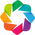

:Chord   [start,end]

In [19]:
hv.extension('bokeh')

unique_labels = list(set(df['Country']).union(set(df['Sales Person'])))
label_map = {label: i for i, label in enumerate(unique_labels)}

links = [(label_map[row['Country']], label_map[row['Sales Person']], row['Amount']) for _, row in df.iterrows()]

nodes = hv.Dataset(pd.DataFrame({'index': list(label_map.values()), 'label': list(label_map.keys())}), 'index')

chord = hv.Chord((links, nodes)).opts(
    opts.Chord(labels='label', cmap='Category20', edge_cmap='viridis', edge_color='Amount', node_color='index', node_size=20, width=800, height=800)
)

chord

# Modelers

In [20]:
# Identify categorical columns
categorical_cols = ['Sales Person', 'Country', 'Product', 'Month']

# Apply one-hot encoding to categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=float)
df

,Date,Amount,Boxes Shipped,Year,Profit,Sales Person_Barr Faughny,Sales Person_Beverie Moffet,Sales Person_Brien Boise,Sales Person_Camilla Castle,Sales Person_Ches Bonnell,...,Product_Smooth Sliky Salty,Product_Spicy Special Slims,Product_White Choc,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8
0,2022-01-04,5320.0,180.0,2022,1064.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-08-01,7896.0,94.0,2022,1579.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2022-07-07,4501.0,91.0,2022,900.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2022-04-27,12726.0,342.0,2022,2545.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2022-02-24,13685.0,184.0,2022,2737.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2022-05-17,4410.0,323.0,2022,882.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1090,2022-06-07,6559.0,119.0,2022,1311.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1091,2022-07-26,574.0,217.0,2022,114.8,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1092,2022-07-28,2086.0,384.0,2022,417.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Data splitting

- Split the data into training and testing sets for model building and evaluation.

In [21]:
# Define features (X) and target (y)
X = df.drop(['Amount', 'Year', 'Date', 'Profit'], axis=1)
y = df['Amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (875, 58)
X_test shape: (219, 58)
y_train shape: (875,)
y_test shape: (219,)


## Model training

- Train several regression models (Decision Tree, Random Forest, and XGBoost) on the prepared training data.

In [22]:
# Initialize models
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
lgb_model = LGBMRegressor(random_state=42)
catb_model = CatBoostRegressor(random_state=42, verbose=0)

# Train Decision Tree model
start_time = time.time()
dt_model.fit(X_train, y_train)
end_time = time.time()
print(f"Decision Tree training time: {end_time - start_time:.2f} seconds")

# Train Random Forest model
start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()
print(f"Random Forest training time: {end_time - start_time:.2f} seconds")

# Train XGBoost model
start_time = time.time()
xgb_model.fit(X_train, y_train)
end_time = time.time()
print(f"XGBoost training time: {end_time - start_time:.2f} seconds")

# Train LightGB model
start_time = time.time()
lgb_model.fit(X_train, y_train)
end_time = time.time()
print(f"LightGB training time: {end_time - start_time:.2f} seconds")

# Train CatBoost model
start_time = time.time()
catb_model.fit(X_train, y_train)
end_time = time.time()
print(f"CatBoost training time: {end_time - start_time:.2f} seconds")

print("Models trained successfully.")

Decision Tree training time: 0.01 seconds
Random Forest training time: 0.52 seconds
XGBoost training time: 0.17 seconds
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 875, number of used features: 58
[LightGBM] [Info] Start training from score 5499.289599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGB training time: 0.09 seconds
CatBoost training time: 0.94 seconds
Models trained successfully.


## Model evaluation

### Subtask:
Evaluate the performance of the trained models (Decision Tree, Random Forest, and XGBoost) on the test data.  If any models failed to train in the previous step, evaluate only the successfully trained models.


**Reasoning**:
Evaluate the performance of the trained models on the test data.



In [23]:
# Make predictions
dt_predictions = dt_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
catb_predictions = catb_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
print(f"Decision Tree MSE: {dt_mse}, MAE: {dt_mae}, R2: {dt_r2}")

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest MSE: {rf_mse}, MAE: {rf_mae}, R2: {rf_r2}")

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)
print(f"XGBoost MSE: {xgb_mse}, MAE: {xgb_mae}, R2: {xgb_r2}")

lgbm_mse = mean_squared_error(y_test, xgb_predictions)
lgbm_mae = mean_absolute_error(y_test, xgb_predictions)
lgbm_r2 = r2_score(y_test, xgb_predictions)
print(f"LightGBM MSE: {lgbm_mse}, MAE: {lgbm_mae}, R2: {lgbm_r2}")

catb_mse = mean_squared_error(y_test, catb_predictions)
catb_mae = mean_absolute_error(y_test, catb_predictions)
catb_r2 = r2_score(y_test, catb_predictions)
print(f"CatBoost MSE: {catb_mse}, MAE: {catb_mae}, R2: {catb_r2}")

model_results = {
    'Decision Tree': {'MSE': dt_mse, 'MAE': dt_mae, 'R2': dt_r2},
    'Random Forest': {'MSE': rf_mse, 'MAE': rf_mae, 'R2': rf_r2},
    'XG Boost': {'MSE': xgb_mse, 'MAE': xgb_mae, 'R2': xgb_r2},
    'LGBM Boost': {'MSE': lgbm_mse, 'MAE': lgbm_mae, 'R2': lgbm_r2},
    'Cat Boost': {'MSE': catb_mse, 'MAE': catb_mae, 'R2': catb_r2},
}

print(model_results)

Decision Tree MSE: 28795369.398881275, MAE: 4362.8762557077625, R2: -1.0879859207613927
Random Forest MSE: 15337924.433760481, MAE: 3202.406091324201, R2: -0.11217084343562034
XGBoost MSE: 18277829.750706032, MAE: 3498.0544635929473, R2: -0.3253468171528511
LightGBM MSE: 18277829.750706032, MAE: 3498.0544635929473, R2: -0.3253468171528511
CatBoost MSE: 17052881.739637557, MAE: 3360.8273753574326, R2: -0.23652440389098084
{'Decision Tree': {'MSE': 28795369.398881275, 'MAE': 4362.8762557077625, 'R2': -1.0879859207613927}, 'Random Forest': {'MSE': 15337924.433760481, 'MAE': 3202.406091324201, 'R2': -0.11217084343562034}, 'XG Boost': {'MSE': 18277829.750706032, 'MAE': 3498.0544635929473, 'R2': -0.3253468171528511}, 'LGBM Boost': {'MSE': 18277829.750706032, 'MAE': 3498.0544635929473, 'R2': -0.3253468171528511}, 'Cat Boost': {'MSE': 17052881.739637557, 'MAE': 3360.8273753574326, 'R2': -0.23652440389098084}}


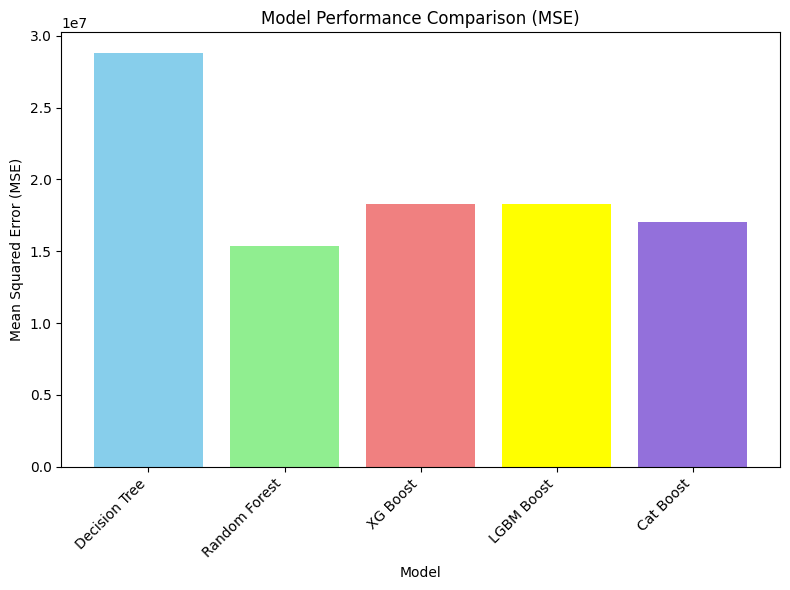

The bar chart visualizes the Mean Squared Error (MSE) for each model. Lower MSE indicates better performance.


In [24]:
model_names = list(model_results.keys())
mse_values = [model_results[model]['MSE'] for model in model_names]

plt.figure(figsize=(8, 6))
plt.bar(model_names, mse_values, color=['skyblue', 'lightgreen', 'lightcoral', 'yellow', 'mediumpurple'])
plt.xlabel("Model")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Model Performance Comparison (MSE)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("The bar chart visualizes the Mean Squared Error (MSE) for each model. Lower MSE indicates better performance.")

## Model optimization

- Optimize the hyperparameters of the Decision Tree, Random Forest, and XGBoost models using Optuna.

In [25]:
# Define an objective function for each model
def objective(trial, model_name):
    global X_train, y_train  # Ensure X_train and y_train are accessible

    if model_name == "DecisionTree":
        params = {
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        }
        model = DecisionTreeRegressor(**params, random_state=42)

    elif model_name == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        }
        model = RandomForestRegressor(**params, random_state=42)

    elif model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
        model = XGBRegressor(**params, random_state=42)

    elif model_name == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 10, 200),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        }
        model = LGBMRegressor(**params, random_state=42, verbose=-1)

    elif model_name == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 50, 300),
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        }
        model = CatBoostRegressor(**params, random_state=42, verbose=0)

    # Evaluate using cross-validation (5 folds)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()
    return -score  # Optuna minimizes the objective function

# Run Optuna optimization
def tune_model(model_name, n_trials=20):
    print(f"Tuning {model_name}...")
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=n_trials)
    print(f"Best parameters for {model_name}: {study.best_params}\n")
    return study.best_params

# Tune each model
dt_params = tune_model("DecisionTree")
rf_params = tune_model("RandomForest")
xgb_params = tune_model("XGBoost")
lgb_params = tune_model("LightGBM")
cat_params = tune_model("CatBoost")

# Train models with best parameters
dt_model = DecisionTreeRegressor(**dt_params, random_state=42)
rf_model = RandomForestRegressor(**rf_params, random_state=42)
xgb_model = XGBRegressor(**xgb_params, random_state=42)
lgb_model = LGBMRegressor(**lgb_params, random_state=42)
cat_model = CatBoostRegressor(**cat_params, random_state=42)

# Train Decision Tree model
start_time = time.time()
dt_model.fit(X_train, y_train)
end_time = time.time()
print(f"Decision Tree training time: {end_time - start_time:.2f} seconds")

# Train Random Forest model
start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()
print(f"Random Forest training time: {end_time - start_time:.2f} seconds")

# Train XGBoost model
start_time = time.time()
xgb_model.fit(X_train, y_train)
end_time = time.time()
print(f"XGBoost training time: {end_time - start_time:.2f} seconds")

# Train LightGBM model
start_time = time.time()
lgb_model.fit(X_train, y_train)
end_time = time.time()
print(f"LightGBM training time: {end_time - start_time:.2f} seconds")

# Train CatBoost model
start_time = time.time()
cat_model.fit(X_train, y_train)
end_time = time.time()
print(f"CatBoost training time: {end_time - start_time:.2f} seconds")

print("Models trained successfully with optimized hyperparameters.")

[I 2025-04-26 14:20:26,459] A new study created in memory with name: no-name-c5c93292-3419-4991-9685-d0a3bdb5cbd2
[I 2025-04-26 14:20:26,499] Trial 0 finished with value: 14987861.525189523 and parameters: {'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 19}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,529] Trial 1 finished with value: 15655644.89778108 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,563] Trial 2 finished with value: 15671617.599125927 and parameters: {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 17}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,598] Trial 3 finished with value: 15671617.599125927 and parameters: {'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 17}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,630] Trial 4 finished with value: 15557

Tuning DecisionTree...


[I 2025-04-26 14:20:26,661] Trial 5 finished with value: 15199304.908696463 and parameters: {'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 17}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,695] Trial 6 finished with value: 15866557.662982538 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 13}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,724] Trial 7 finished with value: 15202968.867865518 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 11}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,755] Trial 8 finished with value: 15166113.231991792 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 19}. Best is trial 0 with value: 14987861.525189523.
[I 2025-04-26 14:20:26,788] Trial 9 finished with value: 15891657.48338241 and parameters: {'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 8}. Best is trial 0

Best parameters for DecisionTree: {'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 19}

Tuning RandomForest...


[I 2025-04-26 14:20:27,867] Trial 0 finished with value: 14661713.473410064 and parameters: {'n_estimators': 62, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 18}. Best is trial 0 with value: 14661713.473410064.
[I 2025-04-26 14:20:30,013] Trial 1 finished with value: 14640378.00511321 and parameters: {'n_estimators': 254, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 15}. Best is trial 1 with value: 14640378.00511321.
[I 2025-04-26 14:20:30,474] Trial 2 finished with value: 14728802.34126155 and parameters: {'n_estimators': 59, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 14640378.00511321.
[I 2025-04-26 14:20:33,462] Trial 3 finished with value: 14955580.50551726 and parameters: {'n_estimators': 279, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 1 with value: 14640378.00511321.
[I 2025-04-26 14:20:33,886] Trial 4 finished with value: 14720865.246704102 and parameters: {'n_est

Best parameters for RandomForest: {'n_estimators': 295, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 20}

Tuning XGBoost...


[I 2025-04-26 14:21:04,117] Trial 0 finished with value: 16683338.284669802 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.1694689274858947, 'subsample': 0.8807999902352022, 'colsample_bytree': 0.6738808164394092}. Best is trial 0 with value: 16683338.284669802.
[I 2025-04-26 14:21:05,179] Trial 1 finished with value: 21611592.917587794 and parameters: {'n_estimators': 186, 'max_depth': 9, 'learning_rate': 0.18580235970134676, 'subsample': 0.6787038066423178, 'colsample_bytree': 0.9934579535950032}. Best is trial 0 with value: 16683338.284669802.
[I 2025-04-26 14:21:05,892] Trial 2 finished with value: 16696849.075941801 and parameters: {'n_estimators': 248, 'max_depth': 4, 'learning_rate': 0.04336419882342398, 'subsample': 0.6152203155181359, 'colsample_bytree': 0.8844464882585519}. Best is trial 0 with value: 16683338.284669802.
[I 2025-04-26 14:21:06,550] Trial 3 finished with value: 19698477.92415511 and parameters: {'n_estimators': 86, 'max_depth': 10, 'l

Best parameters for XGBoost: {'n_estimators': 56, 'max_depth': 7, 'learning_rate': 0.013927801272189962, 'subsample': 0.5468620969344092, 'colsample_bytree': 0.7418734738564123}

Tuning LightGBM...


[I 2025-04-26 14:21:18,172] Trial 0 finished with value: 16893262.26648145 and parameters: {'n_estimators': 163, 'max_depth': 10, 'learning_rate': 0.08888851920897745, 'num_leaves': 194, 'subsample': 0.5140779311818617}. Best is trial 0 with value: 16893262.26648145.
[I 2025-04-26 14:21:18,302] Trial 1 finished with value: 16319329.699548086 and parameters: {'n_estimators': 118, 'max_depth': 5, 'learning_rate': 0.16372642817706665, 'num_leaves': 176, 'subsample': 0.668156439938086}. Best is trial 1 with value: 16319329.699548086.
[I 2025-04-26 14:21:18,518] Trial 2 finished with value: 18522455.61967947 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.28593727718824963, 'num_leaves': 28, 'subsample': 0.8293337818811777}. Best is trial 1 with value: 16319329.699548086.
[I 2025-04-26 14:21:18,585] Trial 3 finished with value: 15475321.205298245 and parameters: {'n_estimators': 74, 'max_depth': 3, 'learning_rate': 0.17679516271772924, 'num_leaves': 23, 'subsample':

Best parameters for LightGBM: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.010155039962494922, 'num_leaves': 54, 'subsample': 0.5263419720690989}

Tuning CatBoost...


[I 2025-04-26 14:21:25,599] Trial 0 finished with value: 18336310.533416104 and parameters: {'iterations': 233, 'depth': 10, 'learning_rate': 0.19491590621208973}. Best is trial 0 with value: 18336310.533416104.
[I 2025-04-26 14:21:26,201] Trial 1 finished with value: 15041172.575474903 and parameters: {'iterations': 58, 'depth': 8, 'learning_rate': 0.06683652789876095}. Best is trial 1 with value: 15041172.575474903.
[I 2025-04-26 14:21:26,490] Trial 2 finished with value: 15176965.73642542 and parameters: {'iterations': 68, 'depth': 4, 'learning_rate': 0.12452669428419098}. Best is trial 1 with value: 15041172.575474903.
[I 2025-04-26 14:21:26,845] Trial 3 finished with value: 16495955.774548974 and parameters: {'iterations': 176, 'depth': 2, 'learning_rate': 0.28271931073188783}. Best is trial 1 with value: 15041172.575474903.
[I 2025-04-26 14:21:27,358] Trial 4 finished with value: 15060118.152615035 and parameters: {'iterations': 146, 'depth': 5, 'learning_rate': 0.045259281693398

Best parameters for CatBoost: {'iterations': 108, 'depth': 3, 'learning_rate': 0.018160547557345762}

Decision Tree training time: 0.00 seconds
Random Forest training time: 0.59 seconds
XGBoost training time: 0.05 seconds
LightGBM training time: 0.01 seconds
0:	learn: 3820.1043289	total: 399us	remaining: 42.8ms
1:	learn: 3819.3317486	total: 902us	remaining: 47.8ms
2:	learn: 3818.2729794	total: 1.36ms	remaining: 47.7ms
3:	learn: 3817.6111363	total: 1.84ms	remaining: 47.9ms
4:	learn: 3816.9978472	total: 2.29ms	remaining: 47.2ms
5:	learn: 3816.1798334	total: 2.77ms	remaining: 47.1ms
6:	learn: 3815.7550506	total: 3.22ms	remaining: 46.4ms
7:	learn: 3814.9003837	total: 3.62ms	remaining: 45.3ms
8:	learn: 3814.4300845	total: 4.02ms	remaining: 44.2ms
9:	learn: 3813.4134740	total: 4.48ms	remaining: 43.9ms
10:	learn: 3812.2730329	total: 4.92ms	remaining: 43.4ms
11:	learn: 3811.6670427	total: 5.32ms	remaining: 42.6ms
12:	learn: 3810.9280705	total: 5.63ms	remaining: 41.1ms
13:	learn: 3810.1404597	t

In [26]:
# Make predictions
dt_predictions = dt_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
print(f"Decision Tree MSE: {dt_mse}, MAE: {dt_mae}, R2: {dt_r2}")

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest MSE: {rf_mse}, MAE: {rf_mae}, R2: {rf_r2}")

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)
print(f"XGBoost MSE: {xgb_mse}, MAE: {xgb_mae}, R2: {xgb_r2}")

lgbm_mse = mean_squared_error(y_test, xgb_predictions)
lgbm_mae = mean_absolute_error(y_test, xgb_predictions)
lgbm_r2 = r2_score(y_test, xgb_predictions)
print(f"LightGBM MSE: {lgbm_mse}, MAE: {lgbm_mae}, R2: {lgbm_r2}")

catb_mse = mean_squared_error(y_test, catb_predictions)
catb_mae = mean_absolute_error(y_test, catb_predictions)
catb_r2 = r2_score(y_test, catb_predictions)
print(f"CatBoost MSE: {catb_mse}, MAE: {catb_mae}, R2: {catb_r2}")

opti_model_results = {
    'Decision Tree': {'MSE': dt_mse, 'MAE': dt_mae, 'R2': dt_r2},
    'Random Forest': {'MSE': rf_mse, 'MAE': rf_mae, 'R2': rf_r2},
    'XG Boost': {'MSE': xgb_mse, 'MAE': xgb_mae, 'R2': xgb_r2},
    'LGBM Boost': {'MSE': lgbm_mse, 'MAE': lgbm_mae, 'R2': lgbm_r2},
    'Cat Boost': {'MSE': catb_mse, 'MAE': catb_mae, 'R2': catb_r2},
}

print(opti_model_results)

Decision Tree MSE: 13992195.599077461, MAE: 3107.556176599699, R2: -0.014590471360589774
Random Forest MSE: 14143490.677776912, MAE: 3141.39235081619, R2: -0.025561054506406666
XGBoost MSE: 13988511.649784736, MAE: 3114.9329520726315, R2: -0.014323343887784779
LightGBM MSE: 13988511.649784736, MAE: 3114.9329520726315, R2: -0.014323343887784779
CatBoost MSE: 17052881.739637557, MAE: 3360.8273753574326, R2: -0.23652440389098084
{'Decision Tree': {'MSE': 13992195.599077461, 'MAE': 3107.556176599699, 'R2': -0.014590471360589774}, 'Random Forest': {'MSE': 14143490.677776912, 'MAE': 3141.39235081619, 'R2': -0.025561054506406666}, 'XG Boost': {'MSE': 13988511.649784736, 'MAE': 3114.9329520726315, 'R2': -0.014323343887784779}, 'LGBM Boost': {'MSE': 13988511.649784736, 'MAE': 3114.9329520726315, 'R2': -0.014323343887784779}, 'Cat Boost': {'MSE': 17052881.739637557, 'MAE': 3360.8273753574326, 'R2': -0.23652440389098084}}


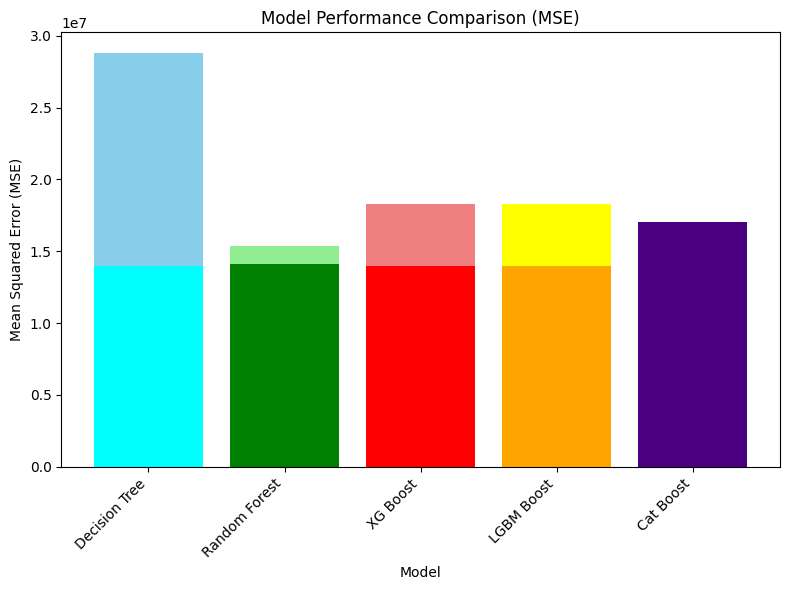

In [27]:
model_names = list(model_results.keys())
mse_values = [model_results[model]['MSE'] for model in model_names]
opti_mse_values = [opti_model_results[model]['MSE'] for model in model_names]

plt.figure(figsize=(8, 6))
plt.bar(model_names, mse_values, color=['skyblue', 'lightgreen', 'lightcoral', 'yellow', 'mediumpurple'])
plt.bar(model_names, opti_mse_values, color=['cyan', 'green', 'red', 'orange', 'indigo'])
plt.xlabel("Model")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Model Performance Comparison (MSE)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [29]:
#shap

# 导入SHAP和其他必要的库
import shap
import matplotlib.pyplot as plt
import numpy as np

# 为XGBoost模型创建SHAP解释器
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)


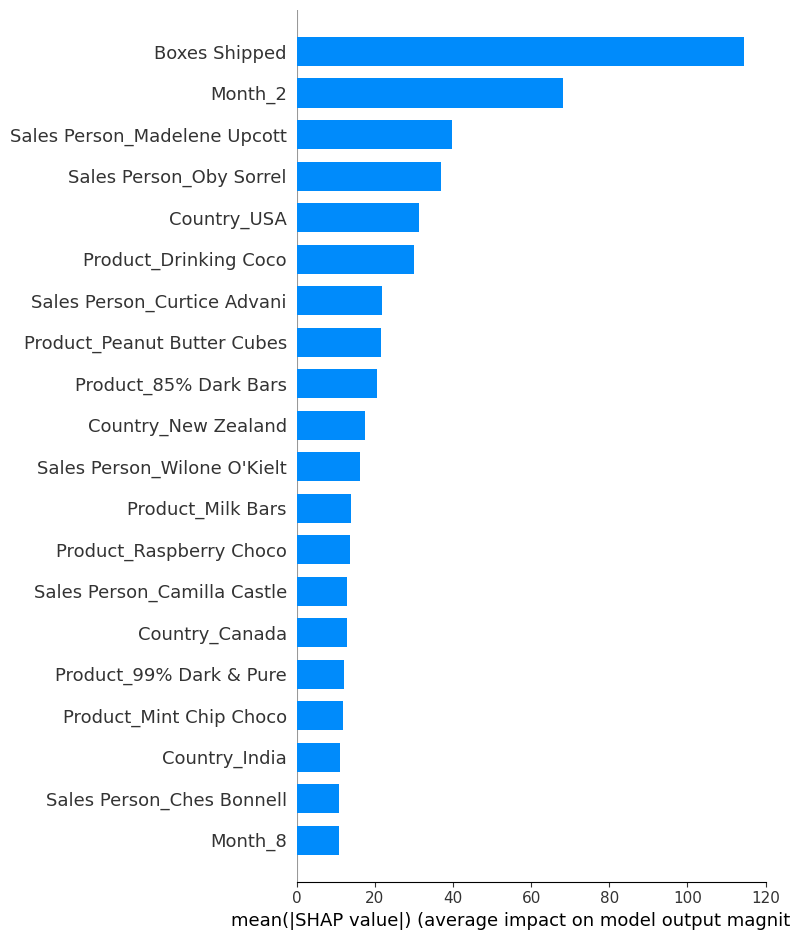

<Figure size 640x480 with 0 Axes>

In [31]:
# 1. 摘要图 - 显示特征重要性和影响方向
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.tight_layout()
plt.savefig("shap_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

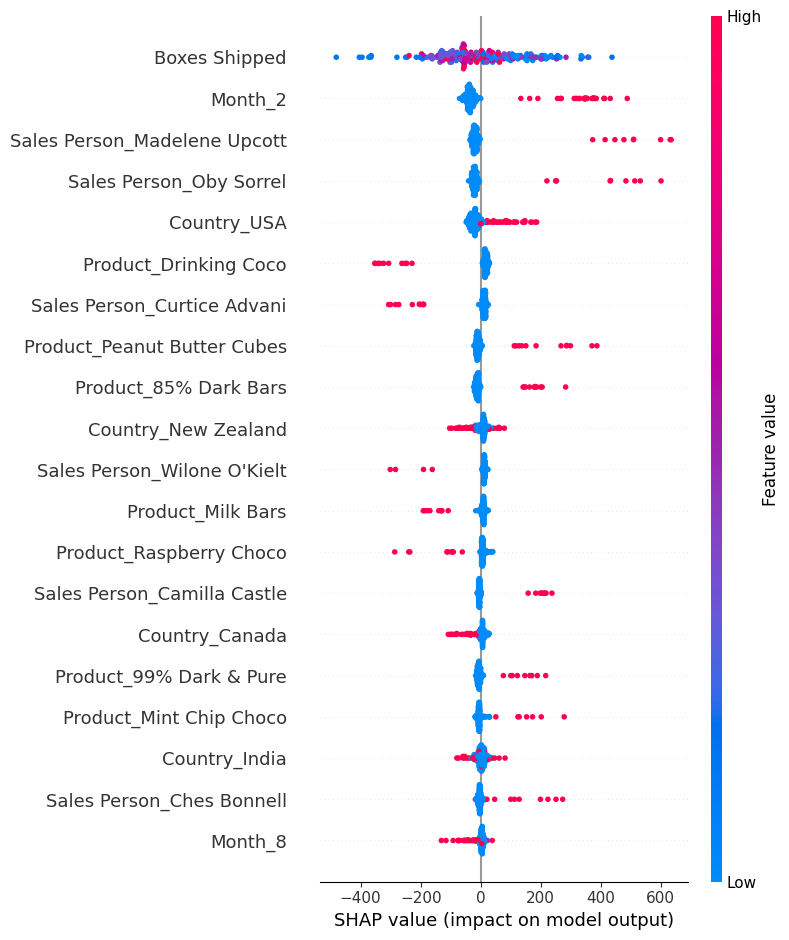

<Figure size 640x480 with 0 Axes>

In [32]:
# 2. 摘要点图 - 显示每个特征的SHAP值分布
shap.summary_plot(shap_values, X_test, plot_type="dot")
plt.tight_layout()
plt.savefig("shap_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
print(X_test.columns)

Index(['Boxes Shipped', 'Sales Person_Barr Faughny',
       'Sales Person_Beverie Moffet', 'Sales Person_Brien Boise',
       'Sales Person_Camilla Castle', 'Sales Person_Ches Bonnell',
       'Sales Person_Curtice Advani', 'Sales Person_Dennison Crosswaite',
       'Sales Person_Dotty Strutley', 'Sales Person_Gigi Bohling',
       'Sales Person_Gunar Cockshoot', 'Sales Person_Husein Augar',
       'Sales Person_Jan Morforth', 'Sales Person_Jehu Rudeforth',
       'Sales Person_Kaine Padly', 'Sales Person_Karlen McCaffrey',
       'Sales Person_Kelci Walkden', 'Sales Person_Madelene Upcott',
       'Sales Person_Mallorie Waber', 'Sales Person_Marney O'Breen',
       'Sales Person_Oby Sorrel', 'Sales Person_Rafaelita Blaksland',
       'Sales Person_Roddy Speechley', 'Sales Person_Van Tuxwell',
       'Sales Person_Wilone O'Kielt', 'Country_Canada', 'Country_India',
       'Country_New Zealand', 'Country_UK', 'Country_USA',
       'Product_70% Dark Bites', 'Product_85% Dark Bars',
     

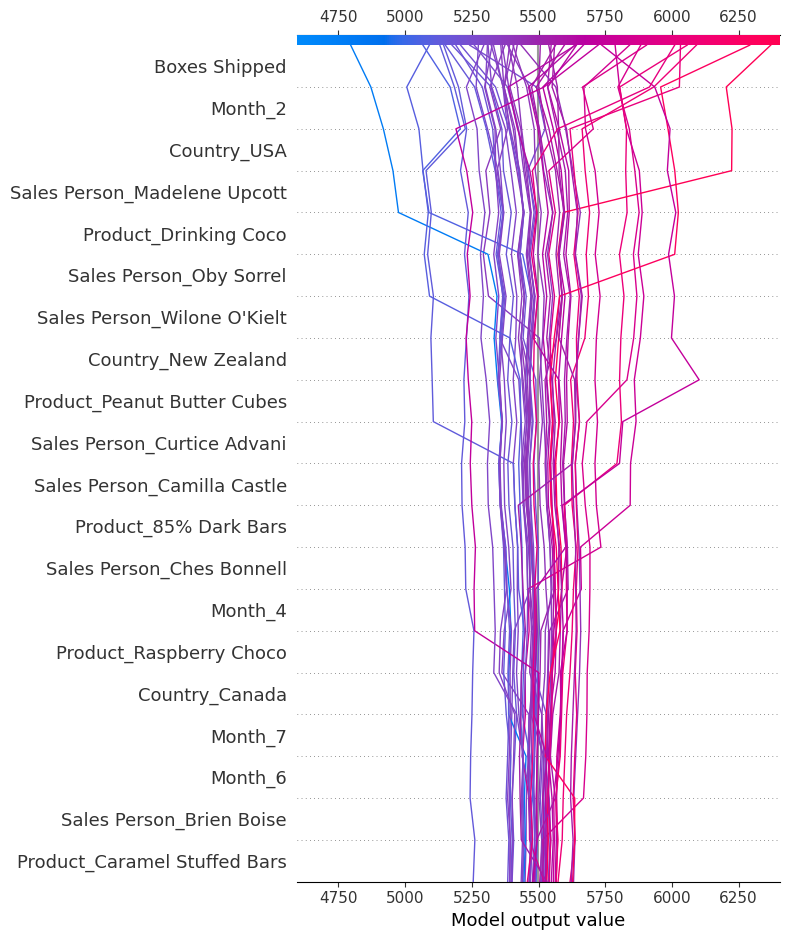

In [41]:
# 4. 决策图 - 显示样本的预测路径

shap.decision_plot(explainer.expected_value, shap_values.values[:50],
                   feature_names=np.array(X_test.columns),
                   show=False)
plt.tight_layout()
plt.savefig("shap_decision_plot.png", dpi=300, bbox_inches='tight')
plt.show()

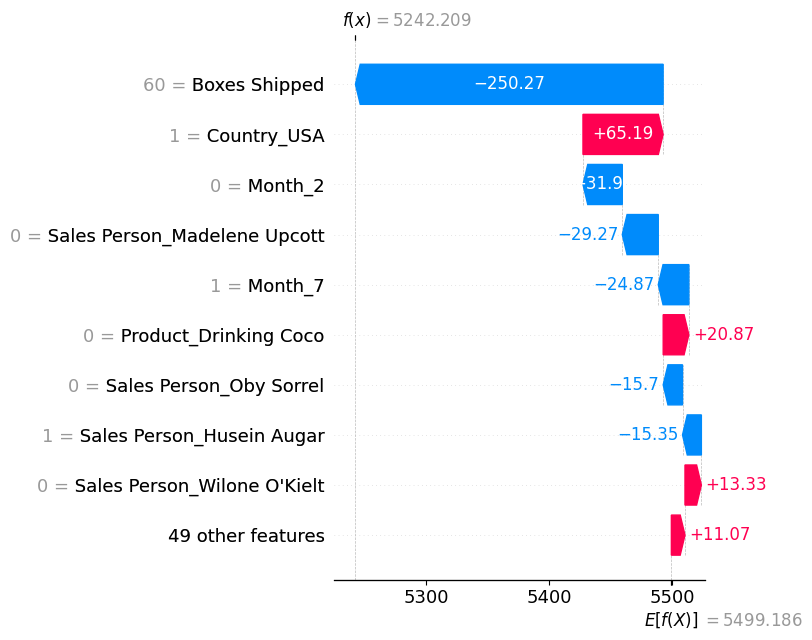

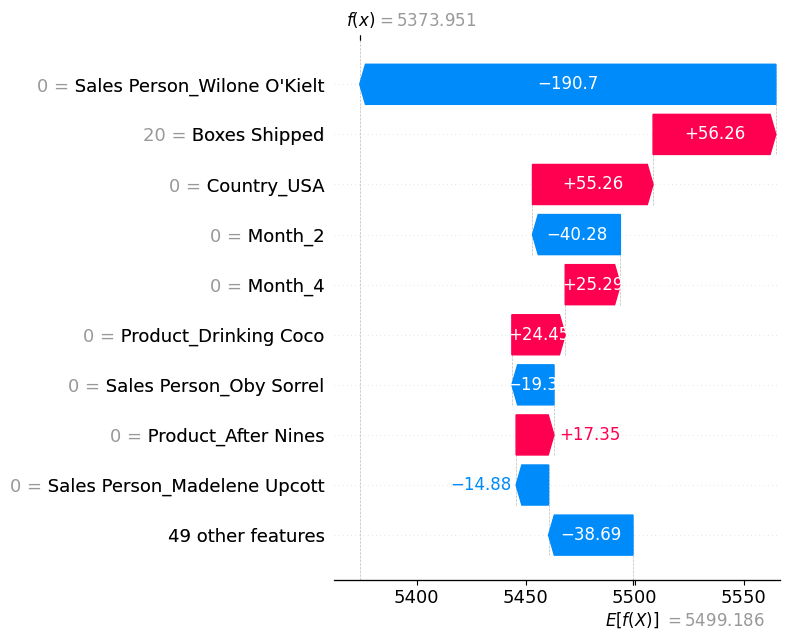

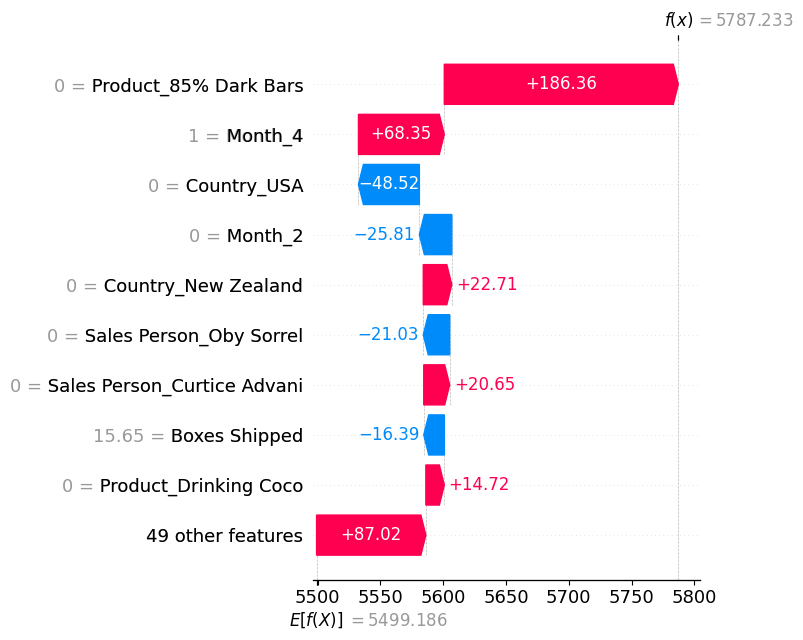

In [44]:
# 5. 瀑布图 - 详细分析多个预测样本
sample_indices = [0, 5, 10]  # 选择多个样本进行对比分析
for i, idx in enumerate(sample_indices):
    plt.figure(figsize=(12, 8))

    # 修改此处，确保负号正常显示
    waterfall = shap.plots.waterfall(shap.Explanation(values=shap_values.values[i],
                                                      base_values=explainer.expected_value,
                                                      data=X_test.iloc[idx],
                                                      feature_names=np.array(X_test.columns)),
                                     show=False)  # 使用新的API并设置show=False
    plt.tight_layout()
    plt.savefig(f"shap_waterfall_sample_{idx}.png", dpi=300, bbox_inches='tight')
    plt.show()

力图解释：
- 力图直观显示每个特征如何推动预测值远离或接近基准值
- 红色表示增加风险的特征值，蓝色表示降低风险的特征值


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`


<Figure size 1400x300 with 0 Axes>

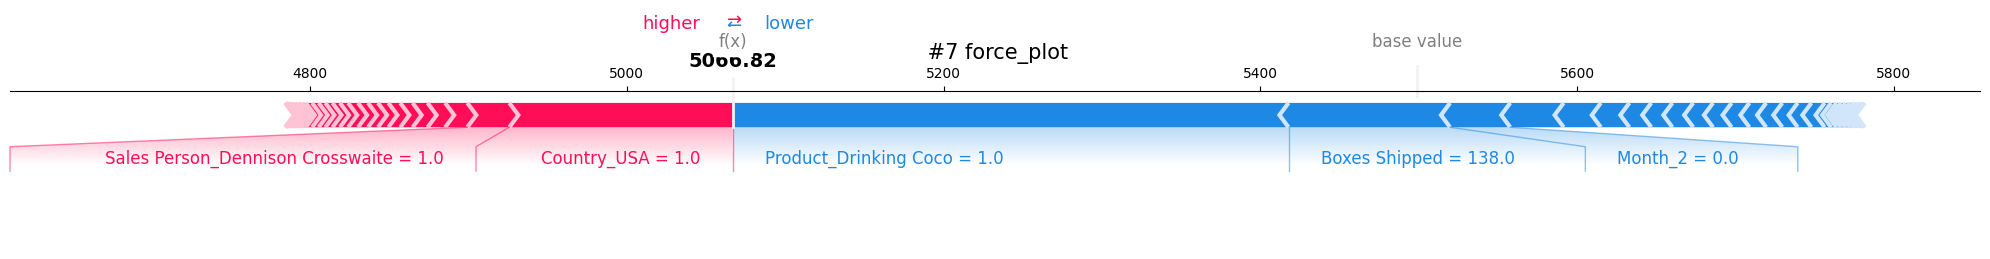

样本 #7 分析:
- 模型预测概率: 100.00%
- 主要风险因素: ['Country_USA', 'Sales Person_Dennison Crosswaite', "Sales Person_Wilone O'Kielt"]
- 主要保护因素: ['Product_Drinking Coco', 'Boxes Shipped', 'Month_2']



<Figure size 1400x300 with 0 Axes>

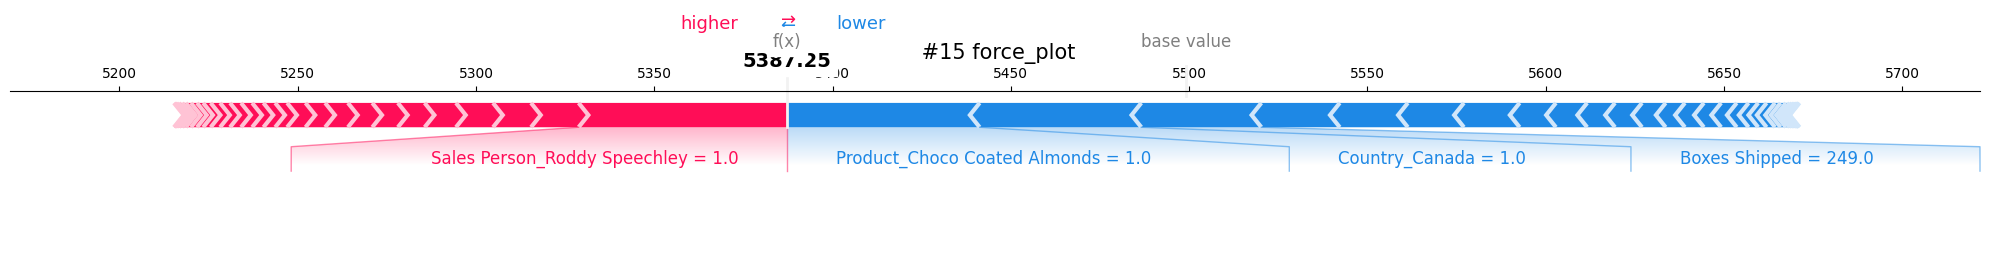

样本 #15 分析:
- 模型预测概率: 100.00%
- 主要风险因素: ['Sales Person_Roddy Speechley', 'Sales Person_Curtice Advani', "Sales Person_Wilone O'Kielt"]
- 主要保护因素: ['Product_Choco Coated Almonds', 'Country_Canada', 'Boxes Shipped']



<Figure size 1400x300 with 0 Axes>

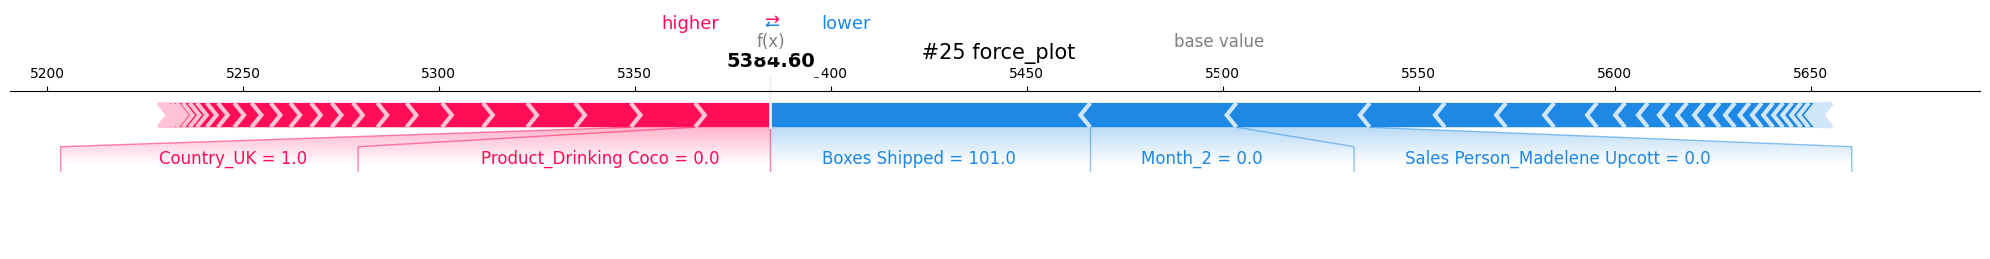

样本 #25 分析:
- 模型预测概率: 100.00%
- 主要风险因素: ['Product_Drinking Coco', 'Country_UK', 'Sales Person_Curtice Advani']
- 主要保护因素: ['Boxes Shipped', 'Month_2', 'Sales Person_Madelene Upcott']



In [49]:
# 6. 力图 - 单个样本预测的特征贡献
# 为多个不同样本创建力图以比较分析
sample_indices = [7, 15, 25]  # 选择多个不同特征的样本
print("力图解释：")
print("- 力图直观显示每个特征如何推动预测值远离或接近基准值")
print("- 红色表示增加风险的特征值，蓝色表示降低风险的特征值")
for sample_idx in sample_indices:
    plt.figure(figsize=(14, 3))
    # 创建样本数据的副本并将其舍入到2位小数
    sample_data = X_test.iloc[sample_idx].copy()  # 使用.iloc进行基于位置的索引
    for i in range(len(sample_data)):
        sample_data[i] = round(sample_data[i], 2)
    # 使用处理后的数据绘制force plot
    shap.force_plot(explainer.expected_value,
                    shap_values.values[sample_idx],
                    sample_data,
                    matplotlib=True,
                    feature_names=np.array(X_test.columns),
                    show=False)
    plt.title(f" #{sample_idx} force_plot", fontsize=15)
    plt.tight_layout()
    plt.savefig(f"shap_force_plot_sample_{sample_idx}.png", dpi=300, bbox_inches='tight')
    plt.show()
    # 计算模型预测概率
    pred_prob = 1 / (1 + np.exp(-explainer.expected_value - np.sum(shap_values.values[sample_idx])))
    print(f"样本 #{sample_idx} 分析:")
    print(f"- 模型预测概率: {pred_prob:.2%}")
    feature_names=np.array(X_test.columns)
    print(f"- 主要风险因素: {[feature_names[i] for i in np.argsort(-shap_values.values[sample_idx])[:3]]}")
    print(f"- 主要保护因素: {[feature_names[i] for i in np.argsort(shap_values.values[sample_idx])[:3]]}")
    print()

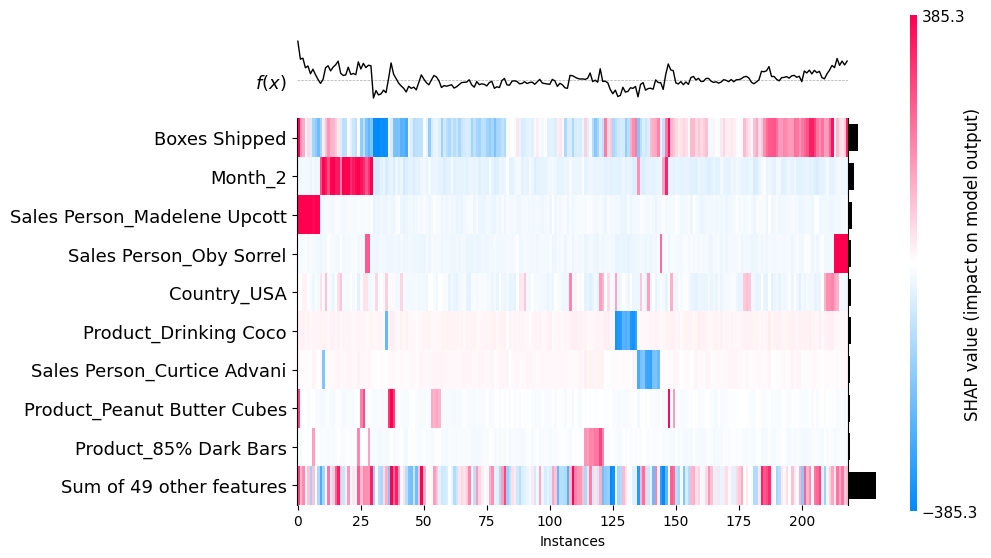

<Figure size 640x480 with 0 Axes>

In [53]:
# 9 SHAP值的热图
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# 绘制 SHAP 热图
shap.plots.heatmap(shap_values)

# 保存或显示图形
plt.savefig("shap_heatmap.png")
plt.show()